# Basic tutorial

<span style="font-variant: small-caps;">Simphony</span> is a Python package designed for **simulating the spin dynamics** of point defects, in particular the nitrogen-vacancy (NV) center, which is surrounded by nuclear spins and serves as a **central-spin quantum register**.

The main goal of this tutorial is to introduce the **core functionalities and concepts** of <span style="font-variant: small-caps;">Simphony</span>. To follow along, you should have a basic understanding of Python, NV centers, and the coherent control of quantum systems.

After the necessary imports, we will introduce the **key components** that define the model of the **central-spin quantum register**. We will demonstrate how to **define time-dependent control pulses** and **simulate the model's time evolution**. Finally, we will show how to **analyze and visualize the simulation results**.

## Import the packages

The package can be imported as:

In [1]:
import simphony

<span style="font-variant: small-caps;">Simphony</span> **supports** simulations on **both CPU and GPU**. The computational platform **must be set immediately after importing the package and before performing any other operations**.

You can set the computational platform as follows (the default is `'cpu'`):

In [2]:
simphony.Config.set_platform('cpu')

As <span style="font-variant: small-caps;">Simphony</span> is based on JAX, it supports **automatic differentiation**, which can be leveraged for pulse optimization. This feature is **disabled by default** and is not used in this tutorial:

In [3]:
simphony.Config.set_autodiff_mode(False)

For better visualization, it is strongly recommended to set the Matplotlib display format to `'retina'` mode:

In [4]:
simphony.Config.set_matplotlib_format('retina')

Furthermore, we import the `numpy` package:

In [5]:
import numpy as np
np.set_printoptions(linewidth=200, precision=4) # to print wide matrices

## Components

The NV electron **spin** can be **initialized** as follows:

In [6]:
spin_e = simphony.Spin(
    dimension = 3,
    name = 'e',
    qubit_subspace = (0, 1),
    gyromagnetic_ratio = 28033.1, # MHz/T
    zero_field_splitting = 2872., # MHz
)

spin_e

Spin(dimension=3, name='e', qubit_subspace=(0, 1), gyromagnetic_ratio=28033.1, zero_field_splitting=2872.0, local_quasistatic_noise=[0, 0, 0])

`dimension = 2` corresponds to **spin-1/2**, `dimension = 3` corresponds to **spin-1**, and so on. Upon initialization, the `quantum_nums` attribute is automatically derived from the given dimension, reflecting the corresponding spin quantum numbers:

In [7]:
spin_e.quantum_nums

(1.0, 0.0, -1.0)

<span style="font-variant: small-caps;">Simphony</span> mainly focuses on the quantum information aspect of the spin model; therefore, **specifying the qubit subspace from the full Hilbert space** of the spin **is required**. The `qubit_subspace` parameter of the `Spin` class must be a **two-element subset** of `quantum_nums`, and the order corresponds to the $\ket{0}$ and $\ket{1}$ qubit basis states.

The **spin operators** are stored in the `operator` attribute, for example, the $x$-component:


In [8]:
spin_e.operator.x

array([[0.    +0.j, 0.7071+0.j, 0.    +0.j],
       [0.7071+0.j, 0.    +0.j, 0.7071+0.j],
       [0.    +0.j, 0.7071+0.j, 0.    +0.j]])

The identity operator corresponding to the spin's Hilbert space is:

In [9]:
spin_e.operator.i

array([[1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j]])

**Pauli operators** defined within the spin's `qubit_subspace` are also available. For example:

In [10]:
spin_e.operator_qubit_subspace.z

array([[-1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j]])

We define the nuclear spin of a **carbon-13** atom:

In [11]:
spin_C = simphony.Spin(
    dimension = 2,
    name = 'C',
    qubit_subspace = (-1/2, 1/2),
    gyromagnetic_ratio = -10.7084, # MHz/T
    zero_field_splitting = 0
)

spin_C

Spin(dimension=2, name='C', qubit_subspace=(-0.5, 0.5), gyromagnetic_ratio=-10.7084, zero_field_splitting=0, local_quasistatic_noise=[0, 0, 0])

We note that all Zeeman terms in the Hamiltonian carry a positive sign (see below), unlike the usual convention in which terms for nuclear spins are negative. Consequently, this results in a **sign difference in the gyromagnetic ratios of the nuclear spins**.

The **hyperfine interaction** between the electron and nuclear spins can be defined using the `Interaction` class:

In [12]:
hyperfine = simphony.Interaction(spin_e, spin_C, tensor=[[-0.0672703,0,0],[0,-0.0672701,0],[0,0,0.0958844]])
hyperfine

Interaction(spin_name_1='e', spin_name_2='C', tensor=[[-0.0672703, 0, 0], [0, -0.0672701, 0], [0, 0, 0.0958844]])

Alternatively, we can create an `Interaction` object with default (zero) components and then set its values individually:

In [13]:
hyperfine = simphony.Interaction(spin_e, spin_C)

hyperfine.xx = -0.0672703 # MHz
hyperfine.yy = -0.0672701 # MHz
hyperfine.zz = 0.0958844 # MHz

hyperfine

Interaction(spin_name_1='e', spin_name_2='C', tensor=[[-0.0672703, 0, 0], [0, -0.0672701, 0], [0, 0, 0.0958844]])

As we can see, the two objects are the same. We can **access the hyperfine tensor**:

In [14]:
hyperfine.tensor

[[-0.0672703, 0, 0], [0, -0.0672701, 0], [0, 0, 0.0958844]]

Or access any **component separately**:

In [15]:
hyperfine.zz

0.0958844

A static magnetic field can be initialized by specifying its component strengths. The **z-component** corresponds to the nitrogen-vacancy axis:

In [16]:
static_field = simphony.StaticField([0,0,0.015]) # T
static_field

StaticField(strengths=[0, 0, 0.015])

An **AC driving magnetic field** can be initialized by specifying a unit vector for its **direction** and a **name**. If the provided direction is not a unit vector, it will be normalized automatically.  

For example, we can define a microwave (MW) field pointing in the **x-direction**:

In [17]:
driving_field_MW = simphony.DrivingField(direction = [1, 0, 0], name = 'MW_x')
driving_field_MW

DrivingField(name='MW_x', direction=[1. 0. 0.])

Additionally, we define a radiofrequency (RF) field pointing in the **y-direction**:

In [18]:
driving_field_RF = simphony.DrivingField(direction = [0, 1, 0], name = 'RF_y')
driving_field_RF

DrivingField(name='RF_y', direction=[0. 1. 0.])

Up to now, we have defined the directions and names of the driving fields. The time dependence will be introduced later using **pulses**, which include details such as frequency and pulse shape.

One of the main objects in <span style="font-variant: small-caps;">Simphony</span> is the `Model` class, which represents the full **central-spin register**. To use it, we first **create an empty model and then populate it with** the previously defined **components**:

In [19]:
model = simphony.Model()

model.add_spin(spin_e)
model.add_spin(spin_C)

model.add_interaction(hyperfine)

model.add_static_field(static_field)
model.add_driving_field(driving_field_MW)
model.add_driving_field(driving_field_RF)

model

Model(spin_names=['e', 'C'], driving_field_names=['MW_x', 'RF_y'], dimension=6)

The **Hamiltonian of the model** can be written as:

$$
H = \underbrace{\gamma_\text{e} B_z S_z + \Delta S_z^2 + \gamma_\text{n} B_z I_z + \boldsymbol{S A I}}_{H_\text{static}} +
\underbrace{B^\text{MW}_x(t)(\gamma_\text{e} S_x + \gamma_\text{n} I_x) + B^\text{RF}_y(t)(\gamma_\text{e} S_y + \gamma_\text{n} I_y)}_{H_\text{driving}},
$$

where:
* $\boldsymbol{S} = (S_x, S_y, S_z)$ and $\boldsymbol{I} = (I_x, I_y, I_z)$ are the spin operators of the electron and nuclear spins, respectively.
* $\gamma_\text{e}$ and $\gamma_\text{n}$ are the gyromagnetic ratios of the electron and nuclear spins, respectively.
* $B_z$ is the static magnetic field.
* $\Delta$ is the zero-field splitting of the electron spin.
* $\boldsymbol{A}$ is the hyperfine tensor.
* $B^\text{MW}_x(t)$ and $B^\text{RF}_y(t)$ are the AC magnetic fields (MW and RF).

In <span style="font-variant: small-caps;">Simphony</span>, we use the **$h = 1$ convention**, which means that the **unit of our Hamiltonians is frequency** (not angular frequency).

The **static Hamiltonian is a time-independent operator**, which can be calculated using the `calculate_static_hamiltonian()` method, and the result is stored in the `static_hamiltonian` attribute:

In [20]:
model.calculate_static_hamiltonian()
model.static_hamiltonian

array([[ 3.2925e+03+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j, -7.0711e-08+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j],
       [ 0.0000e+00+0.j,  3.2925e+03+0.j, -4.7567e-02+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j],
       [ 0.0000e+00+0.j, -4.7567e-02+0.j, -8.0313e-02+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j, -7.0711e-08+0.j],
       [-7.0711e-08+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j,  8.0313e-02+0.j, -4.7567e-02+0.j,  0.0000e+00+0.j],
       [ 0.0000e+00+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j, -4.7567e-02+0.j,  2.4514e+03+0.j,  0.0000e+00+0.j],
       [ 0.0000e+00+0.j,  0.0000e+00+0.j, -7.0711e-08+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j,  2.4516e+03+0.j]])

The **Hamiltonian basis** consists of the product states of the spins, ordered according to the composite quantum numbers:

In [21]:
model.basis

[(1.0, 0.5), (1.0, -0.5), (0.0, 0.5), (0.0, -0.5), (-1.0, 0.5), (-1.0, -0.5)]

The **driving Hamiltonian** is a time-dependent operator that can be expressed as the product of:

* a **time-independent operator** part: $\gamma_\text{e} S_x + \gamma_\text{n} I_x$ and $\gamma_\text{e} S_y + \gamma_\text{n} I_y$ (we will refer to these as **driving operators**)
* a **time-dependent scalar** part: $B^\text{MW}_x(t)$ and $B^\text{RF}_y(t)$ (we will refer to this as **pulse**)

The `driving_operators` can be calculated using:

In [22]:
model.calculate_driving_operators()
model.driving_operators

[array([[ 0.0000e+00+0.j, -5.3542e+00+0.j,  1.9822e+04+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j],
        [-5.3542e+00+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j,  1.9822e+04+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j],
        [ 1.9822e+04+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j, -5.3542e+00+0.j,  1.9822e+04+0.j,  0.0000e+00+0.j],
        [ 0.0000e+00+0.j,  1.9822e+04+0.j, -5.3542e+00+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j,  1.9822e+04+0.j],
        [ 0.0000e+00+0.j,  0.0000e+00+0.j,  1.9822e+04+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j, -5.3542e+00+0.j],
        [ 0.0000e+00+0.j,  0.0000e+00+0.j,  0.0000e+00+0.j,  1.9822e+04+0.j, -5.3542e+00+0.j,  0.0000e+00+0.j]]),
 array([[0.+0.0000e+00j, 0.+5.3542e+00j, 0.-1.9822e+04j, 0.+0.0000e+00j, 0.+0.0000e+00j, 0.+0.0000e+00j],
        [0.-5.3542e+00j, 0.+0.0000e+00j, 0.+0.0000e+00j, 0.-1.9822e+04j, 0.+0.0000e+00j, 0.+0.0000e+00j],
        [0.+1.9822e+04j, 0.+0.0000e+00j, 0.+0.0000e+00j, 0.+5.3542e+00j, 0.-1.9822e+04j, 0.+0.0000e+00j],
        

The `static_hamiltonian` and `driving_operators` can both be calculated using the **`calculate_hamiltonians()`** method.

Notes:
* After the Hamiltonians are calculated, **adding further components** (such as additional spins, interactions, or static/driving fields) to the model **is not allowed** and will result in an error.
* It is **possible to add pulses to the driving fields** and modify them either **before or after calculating the Hamiltonians**.

We can now **visualize the energy levels** of the static Hamiltonian using the `plot_levels()` method:
* Left subfigure: **Full spectrum** ($3 \times 2$ states), dominated by the electron spin splitting.
* Three right subfigures: **Splitting of the nuclear spin** corresponding to the **different electron spin states** $m_S = (-1, 0, 1)$.
* This plot works well only if the gyromagnetic ratio of the first spin is much larger than that of the others. For an NV center, the intended usage is that the **electron spin should be the first spin added** to the model.

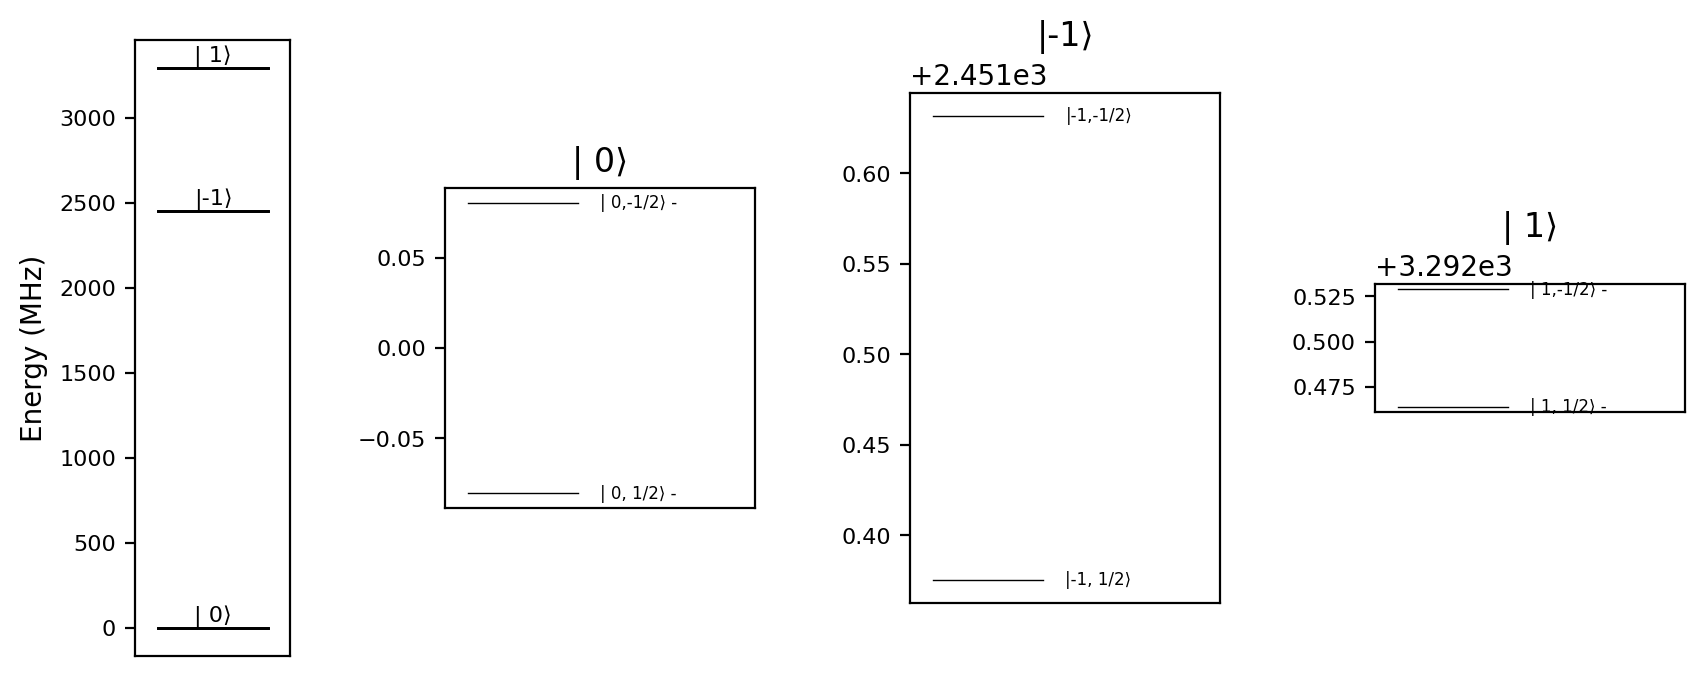

In [23]:
model.plot_levels()

Eigenenergies of the static Hamiltonian can be obtained using the `eigenenergy()` method. The `quantum_nums` must be specified as an argument. **Eigenstates and eigenenergies are labeled by the quantum numbers of the product basis state that has the largest overlap with the given eigenstate.**

The `quantum_nums` should be provided as a **tuple containing the quantum numbers** in the same order as indicated by the `spin_names` attribute:

In [24]:
model.eigenenergy(quantum_nums=(-1,-1/2))

np.float64(2451.6317551999996)

Alternatively, we can specify it **as a dictionary**, where the keys correspond to the spin names and the values correspond to the quantum numbers:

In [25]:
model.eigenenergy(quantum_nums={'C': -1/2, 'e': -1})

np.float64(2451.6317551999996)

Due to the $h = 1$ convention, **energies** are equivalent to frequencies and are expressed in $\mathbf{MHz}$.

Eigenstates of the static Hamiltonian can be calculated using the `eigenstate()` method:

In [26]:
model.eigenstate(quantum_nums={'C': -1/2, 'e': -1})

array([-5.1360e-41+0.j, -1.6315e-15+0.j, -2.8841e-11+0.j, -3.6226e-31+0.j,  9.2769e-32+0.j,  1.0000e+00+0.j])

The returned quantum state is expressed as a vector of coefficients with respect to the product basis states. The **product basis states** can be obtained using the `productstate()` method:

In [27]:
model.productstate(quantum_nums={'C': -1/2, 'e': -1})

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])

Knowledge of the **energy splittings** of the model is essential for coherent control of a quantum system.  We can calculate the splittings using the `splitting()` method:


In [28]:
model.splitting(spin_name='e', quantum_nums=(0,-1), rest_quantum_nums={'C': -1/2})

np.float64(2451.551443123038)

The method returns the energy splitting between two eigenstates of the model. The **two eigenstates must differ only in a single quantum number**, which is characterized by the `spin_name` and its two `quantum_nums`. The quantum numbers of the remaining spins are provided in `rest_quantum_numbers` as a dictionary. There is an alternative method to calculate the **splittings if we restrict ourselves to the qubit subspace**, i.e., the `splitting_qubit()` method automatically returns the qubit splitting corresponding to the spin specified with `spin_name`:

In [29]:
splitting_m = model.splitting_qubit(spin_name='e', rest_quantum_nums={'C': -1/2})
splitting_p = model.splitting_qubit(spin_name='e', rest_quantum_nums={'C': 1/2})

[splitting_m, splitting_p]

[np.float64(3292.4485594102275), np.float64(3292.5444428871874)]

If `rest_quantum_nums` is not provided, the **splitting is averaged** over all possible configurations of the remaining spins, i.e., while all other spins take on every possible value from their `quantum_nums` set:

In [30]:
spitting = model.splitting_qubit(spin_name='e')
[spitting, (splitting_m + splitting_p)/2]

[np.float64(3292.4965011487075), np.float64(3292.4965011487075)]

To implement quantum gates using pulses, we perform rotations on the Bloch sphere. The most common approach is to use **resonant pulses with rectangular envelopes**. Calculating the appropriate pulse **strength or duration** — given the other — is essential. The `rabi_cycle_time()` method determines the period of a Rabi oscillation under a constant-strength driving field, while the `rabi_cycle_amplitude()` method calculates the required amplitude for a given period. The `rabi_cycle_time_qubit()` and `rabi_cycle_amplitude_qubit()` variants simplify this process when working in the qubit subspace.

For example, here we calculate the strength of an AC radiofrequency driving field required to produce Rabi oscillations of the nuclear spin with a period of $100~\mu\text{s}$:

In [31]:
amplitude = model.rabi_cycle_amplitude_qubit(driving_field_name='RF_y',
                                             period_time=100, # us
                                             spin_name='C',
                                             rest_quantum_nums={'e': 0})
print('amplitude = {} T'.format(amplitude))

amplitude = 0.002135300641534497 T


We can check whether the `amplitude` corresponds to the period we set above:

In [32]:
period_time = model.rabi_cycle_time_qubit(driving_field_name='RF_y',
                                          amplitude=amplitude, # T
                                          spin_name='C',
                                          rest_quantum_nums={'e': 0})
print('period time = {} us'.format(period_time))

period time = 100.0 us


We note that **times** in <span style="font-variant: small-caps;">Simphony</span> are expressed in **microseconds** ($\mu\text{s}$).

## Adding pulses

The primary purpose of <span style="font-variant: small-caps;">Simphony</span> is to simulate the **time evolution** of a spin register governed by time-dependent **pulse sequences**. Users can add pulses to **driving fields**. Driving fields can be accessed from the model via the `driving_fields` attribute (which provides a list of driving field objects) or using the `driving_field(name: str)` method, which returns the corresponding field. The names of all driving fields are stored in the `driving_field_names` attribute.

In this tutorial, we use **rectangular pulses** exclusively. Due to the hyperfine interaction, the electron spin energy splitting depends on the nuclear spin state, making it nontrivial to apply a pulse that is resonant with the electron spin regardless of the state of the nuclear spin. To address this, the pulse frequency is set to the **average electron splitting** for the two nuclear spin states. A strong driving field (with **Rabi frequency** greater than the hyperfine interaction strength) ensures that the electron spin can be rotated irrespective of the nuclear spin state. The pulse duration is chosen as **half of the Rabi period**, thereby realizing a $\pi$ rotation:

In [33]:
amplitude = 0.004 # T
splitting_frequency_e = model.splitting_qubit('e')
phase = 0
duration = 0.5 * model.rabi_cycle_time_qubit('MW_x', amplitude, 'e')

model.driving_field('MW_x').add_rectangle_pulse(amplitude=amplitude,
                                                frequency=splitting_frequency_e,
                                                phase=phase,
                                                duration=duration)

To **visualize the driving fields**, use the `plot_driving_fields()` method:

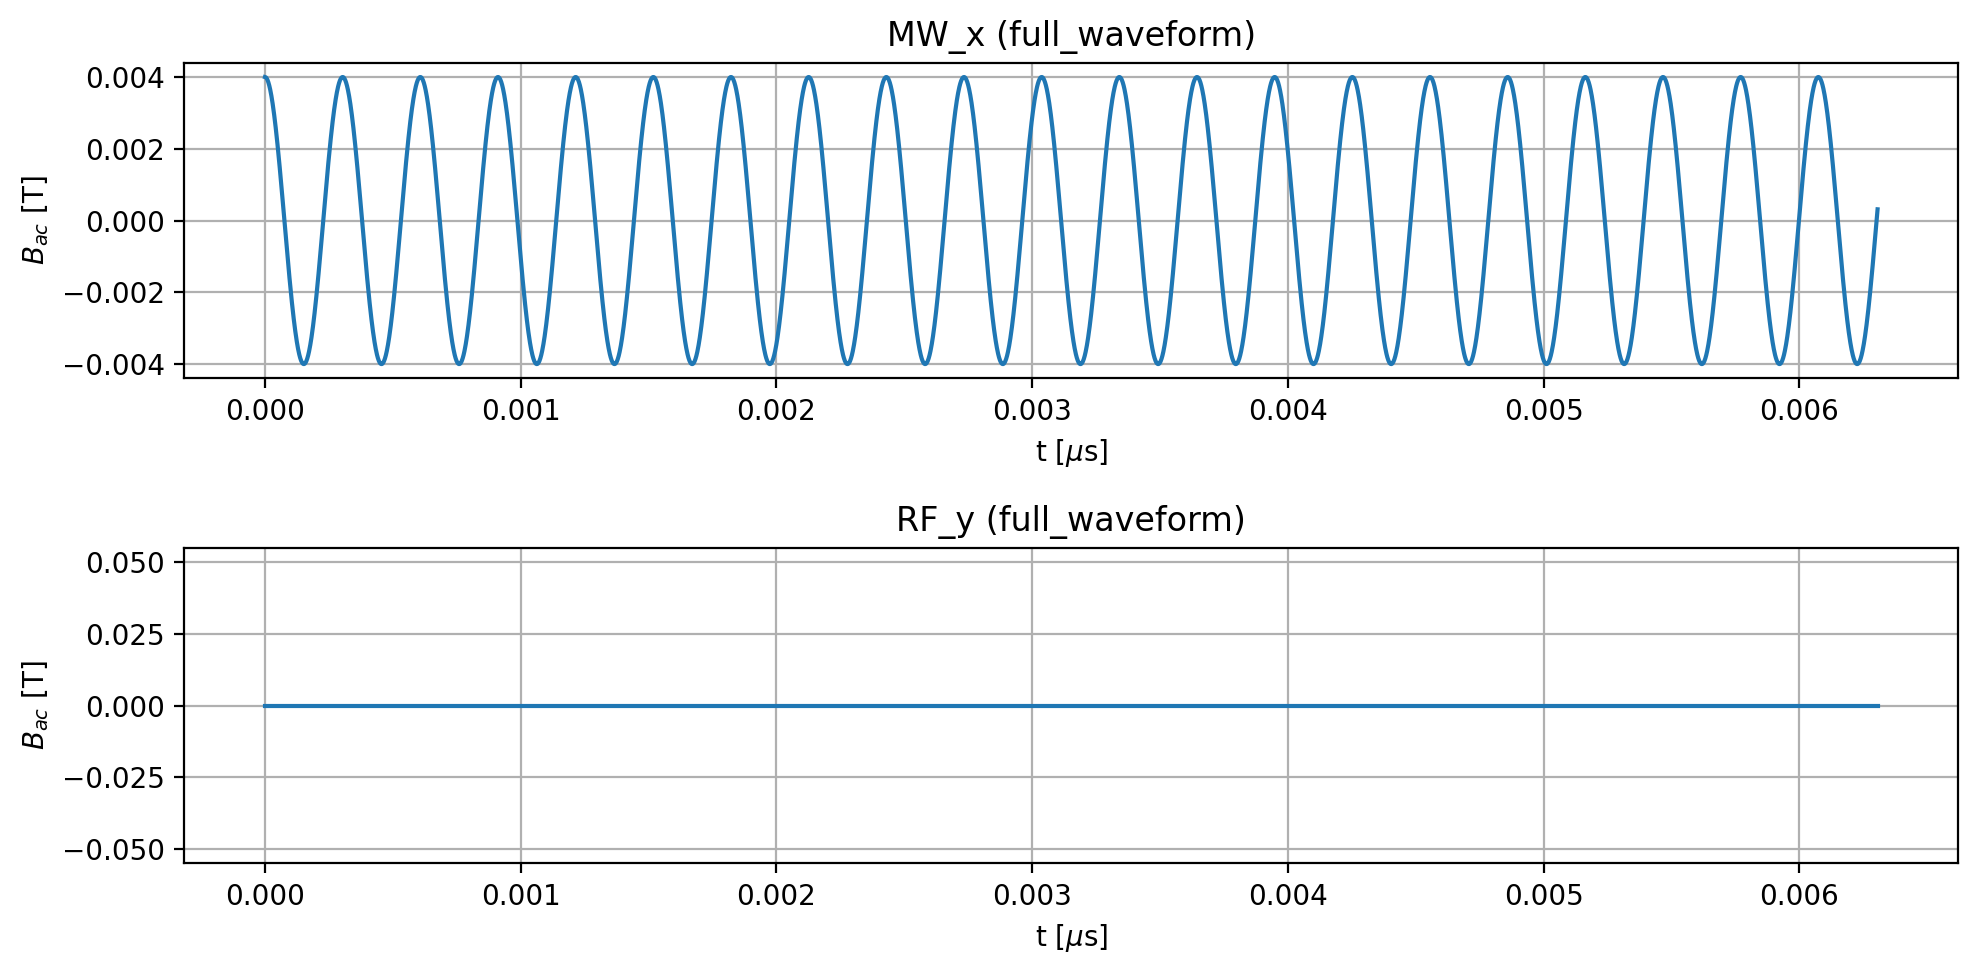

In [34]:
model.plot_driving_fields()

To **plot a specific driving field**, select it by name and use the `plot_pulses()` method:

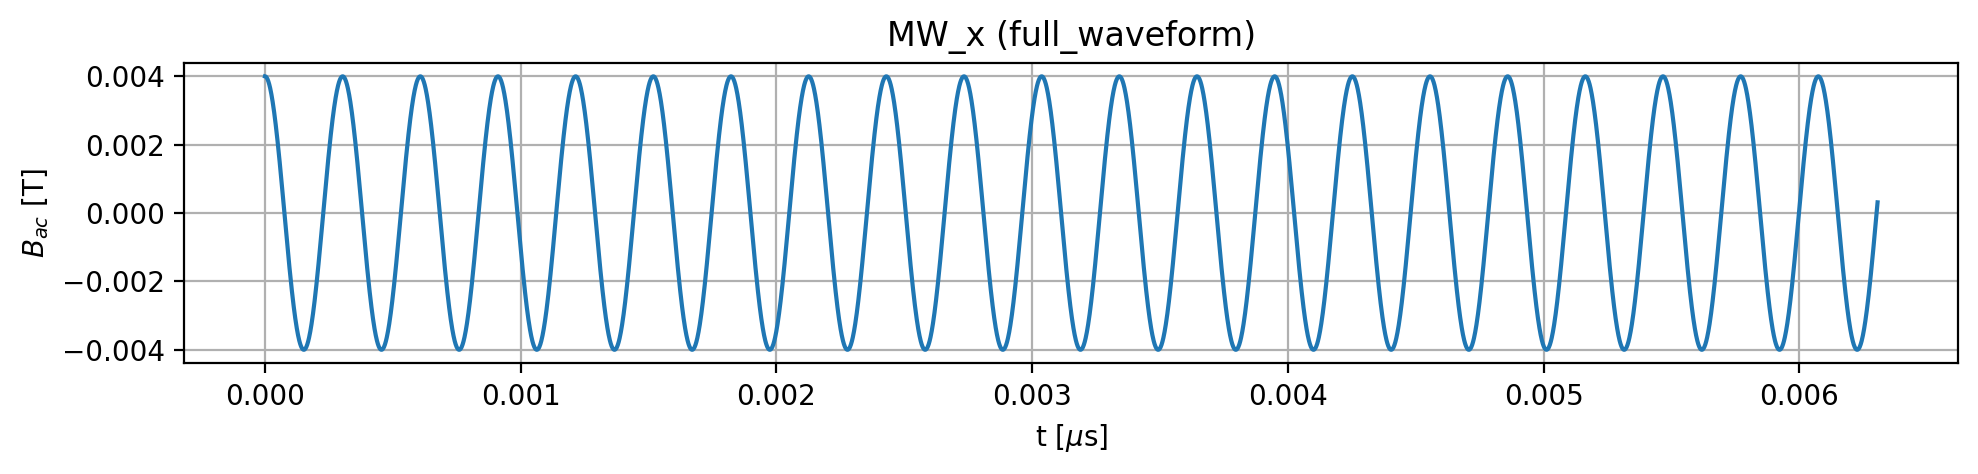

In [35]:
model.driving_field('MW_x').plot_pulses()

To display only the **complex envelope of the pulse**, use the `function='complex_envelope'` option (by default: `function='full_waveform'`):

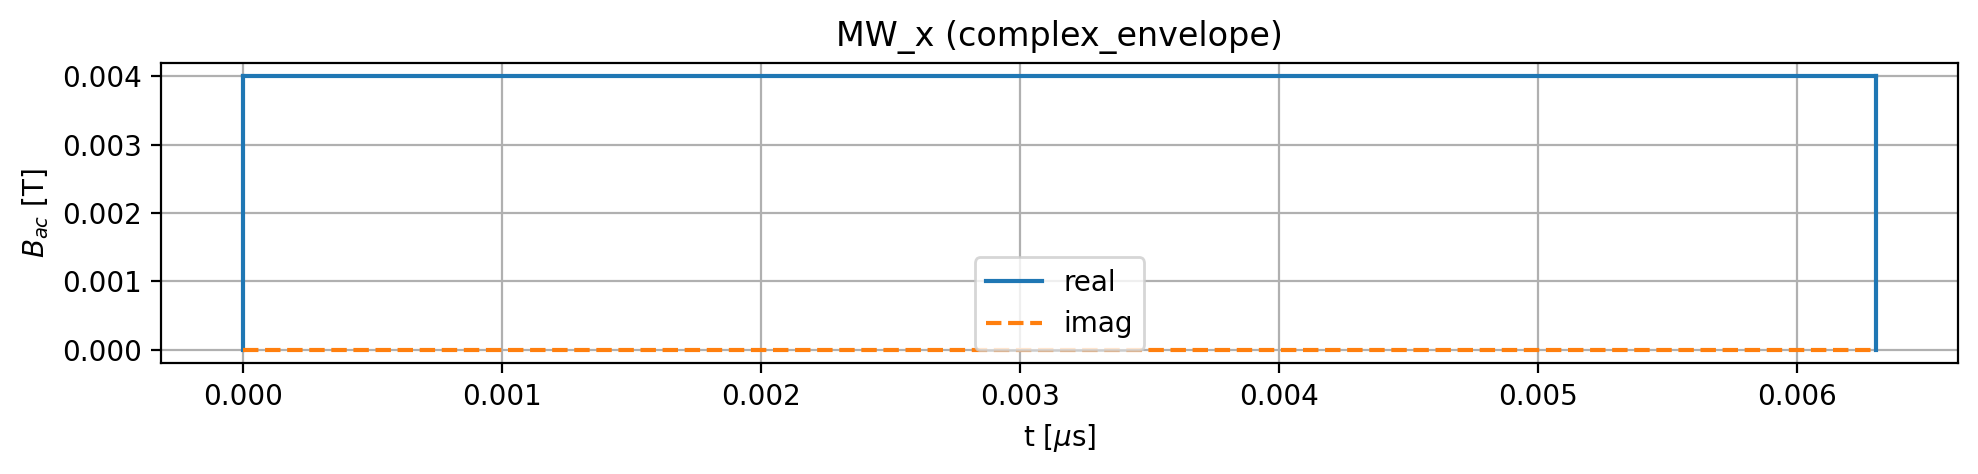

In [36]:
model.driving_field('MW_x').plot_pulses(function='complex_envelope')

You can **reset all driving fields** using the `remove_all_pulses()` method (not executed here):

In [37]:
# model.remove_all_pulses()

The `remove_all_pulses()` method removes all pulses from the driving fields, but the **driving fields themselves remain in the model**.

An alternative way to add pulses to the model is by using the `Pulse` class:

In [38]:
pulse1 = simphony.Pulse(
    start=1,
    end=2,
    frequency=splitting_frequency_e,
    complex_envelope=0.01 + 0.02 * 1j
)

The `complex_envelope` can be provided as a Python function (callable):

In [39]:
def complex_envelope_fn(t):
    return 0.01 * 1j * np.exp(t)

pulse2 = simphony.Pulse(
    start=2.5,
    end=3,
    frequency=splitting_frequency_e,
    complex_envelope=complex_envelope_fn
)

And you can simply add the pulse using the `add_pulse()` method (not executed here):

In [40]:
# model.driving_field('MW_x').add_pulse(pulse2)

## Rotating frame

The rotating frame is often introduced to simplify the description of the time evolution of quantum systems. **Gates realized by pulse sequences are usually interpreted in the rotating frame**. In <span style="font-variant: small-caps;">Simphony</span>, the operator corresponding to the rotating frame has the form:

$$
U_\text{rotating}(t) = \prod_{i \in \text{spins}} e^{i 2\pi f_i t \sigma_{z,i} / 2}.
$$

The **rotating frame frequencies** can be set for each spin individually. For example, we fix the rotating frame frequency of the electron spin to the excitation frequency:


In [41]:
spin_e.rotating_frame_frequency = splitting_frequency_e

The rotating frame frequencies can be retrieved together using:

In [42]:
model.rotating_frame_frequencies

array([3292.4965,    0.    ])

Note that **simulations are performed in the lab frame**. However, the rotating frame is used to interpret the time evolution as a gate in that frame.

## Running Simulations

The primary functionality of <span style="font-variant: small-caps;">Simphony</span> is running simulations. This is currently done by **solving the time-dependent Schrödinger equation in an exact way (without the rotating wave approximation)**. As a result, the **time-dependent evolution operator is computed exactly** and made available for further analysis.

<span style="font-variant: small-caps;">Simphony</span> is designed to simulate pulse sequences composed of microwave and radio-frequency pulses, usually applied alternately. In the background, the simulated pulse sequence is divided into **time segments defined by the start and end boundaries of each pulse**. Each time segment is associated with the pulses active during that segment. The time-dependent Schrödinger equation is solved over these **segments** using a **discretized** approach. The **resolution is set according to the highest pulse frequency**, with time steps corresponding to one 250th (by default) of its period. If a time segment contains a **single pulse** with a constant envelope, <span style="font-variant: small-caps;">Simphony</span> simplifies the simulation: only a **single sine wave is simulated** and used to reconstruct the full pulse time evolution.

The `simulate_time_evolution()` method, when called without parameters, runs a default simulation. However, it is highly customizable. The **most important parameters** include:

- `end`: The end time of the simulation (default: end of the last pulse)
- `n_eval`: The number of time points returned per simulation segment (default: `251`)
- `simulation_method`: It must be `'basic'` or `'single_sine_wave'` (default: `'single_sine_wave'`)
- `n_split`: Number of split points per time segments (default: `250`)
- `apply_noise`: Whether to include noise in the simulation (default: `True`)
- `n_shots`: For noisy simulations, the number of different noise realizations (default: `1`)

The `simulate_time_evolution()` method **returns the simulation results** as an instance of the `SimulationResult` class:

In [43]:
result = model.simulate_time_evolution(verbose=True)
result

start = 0.0
end = 0.006305998814134139
solver_method = jax_expm
number of simulated driving terms = 1
number of simulated noise terms = 0
---------------------------------------------------------------------------
simulate time segment [0.00000, 0.00631] with step size 1.215e-06 (type: single_sine_wave)


SimulationResult(model_dimension=6, n_shots=1, n_ts=251)

It is important to note that the **simulation time strongly depends on the number of returned time points**, which is controlled by the `n_eval` parameter. **If only the final result of the pulse sequence is needed, setting** `n_eval=2` **can significantly speed up the simulation**. However, even in this case, <span style="font-variant: small-caps;">Simphony</span> may still return intermediate results at the end of each simulation segment, not only at the final time point.

The returned instance stores the **main details of the simulation**:
* `model`: the simulated model
* `ts`: timestamps of the stored simulation data
* `time_evol_operator`: time-evolution operator corresponding to the dynamics (by default, this is the direct result of the simulation)

The **time-evolution operators are stored** as an instance of the `TimeEvolOperator` class:

In [44]:
result.time_evol_operator

TimeEvolOperator(dimension=6, n_shots=1, n_ts=251)

The **matrix representation** of the time-evolution operator can be obtained using the `matrix()` method. Its arguments are:

* `basis`: must be either `'product'` or `'eigen'`
* `frame`: must be either `'lab'` or `'rotating'`
* `t_idx`: indices of the time points
* `shot`: index or indices of the shots (see later)

In [45]:
result.time_evol_operator.matrix(basis='eigen', frame='rotating', t_idx=[0,-1], shot=[0])

array([[[[ 1.0000e+00+0.0000e+00j, -4.0885e-22+0.0000e+00j,  4.7237e-32+0.0000e+00j,  1.6634e-26+0.0000e+00j,  5.9165e-31+0.0000e+00j, -4.3578e-41+0.0000e+00j],
         [-4.0885e-22+0.0000e+00j,  1.0000e+00+0.0000e+00j,  6.7763e-21+0.0000e+00j,  2.2203e-16+0.0000e+00j, -5.8352e-16+0.0000e+00j, -3.9443e-31+0.0000e+00j],
         [ 4.7237e-32+0.0000e+00j,  6.7763e-21+0.0000e+00j,  1.0000e+00+0.0000e+00j,  3.2077e-21+0.0000e+00j, -8.4296e-21+0.0000e+00j,  6.4623e-27+0.0000e+00j],
         [ 1.6634e-26+0.0000e+00j,  2.2203e-16+0.0000e+00j,  3.2077e-21+0.0000e+00j,  1.0000e+00+0.0000e+00j,  3.3881e-21+0.0000e+00j, -3.6224e-31+0.0000e+00j],
         [ 5.9165e-31+0.0000e+00j, -5.8352e-16+0.0000e+00j, -8.4296e-21+0.0000e+00j,  3.3881e-21+0.0000e+00j,  1.0000e+00+0.0000e+00j,  1.0447e-30+0.0000e+00j],
         [-4.3578e-41+0.0000e+00j, -3.9443e-31+0.0000e+00j,  6.4623e-27+0.0000e+00j, -3.6224e-31+0.0000e+00j,  1.0447e-30+0.0000e+00j,  1.0000e+00+0.0000e+00j]],

        [[ 7.2033e-03-1.1641e-02

The returned `np.array` has 4 dimensions: axis 0 corresponds to different shots, axis 1 to time points, and axes 2 and 3 represent the time-evolution operator as a matrix.

Using the `result` object, you can calculate and visualize:
* the **expectation values of operators** during the time evolution starting from an initial state
* the **process matrix** corresponding to the final propagator
* the **average gate fidelity** with respect to an ideal gate
* the **leakage** from the qubit subspace

## Expectation values

Before calculating expectation values, an **initial state must be defined**:

In [46]:
result.initial_state = model.productstate({'e': 0, 'C': -1/2})

In the background, the **time-evolved states corresponding to the time points** are computed using the time-evolution operators:

In [47]:
result.time_evol_state

TimeEvolState(dimension=6, n_shots=1, n_ts=251)

To calculate expectation values, use the `expectation_value()` method. The **operator** should be provided as an `np.array` whose dimensions match the model's full Hilbert space. Alternatively, if you only want to apply the operator within the qubit subspace, set `in_qubit_subspace=True`. In that case, the operator should match the size of the qubit subspace.

Another option is to specify the operator as a **Pauli string** acting on the qubit subspace of the spin register. The order of qubits should correspond to `model.spin_names`. Note that any operator input can also be provided as a list of such operators.

For example, we can calculate the Bloch vector components of the electron spin at the first and last timestamps as follows:

In [48]:
result.expectation_value(['XI','YI','ZI'], t_idx=[0,-1])

array([[[ 0.    ,  0.    ,  1.    ],
        [ 0.0257, -0.0027, -0.9981]]])

The shape corresponds to `shots` × `time points` × `operators`. **By default**, the calculation is performed **in the product basis and in the rotating frame**. Without retrieving the numerical values, we can plot the expectation values at once (here in the lab frame):

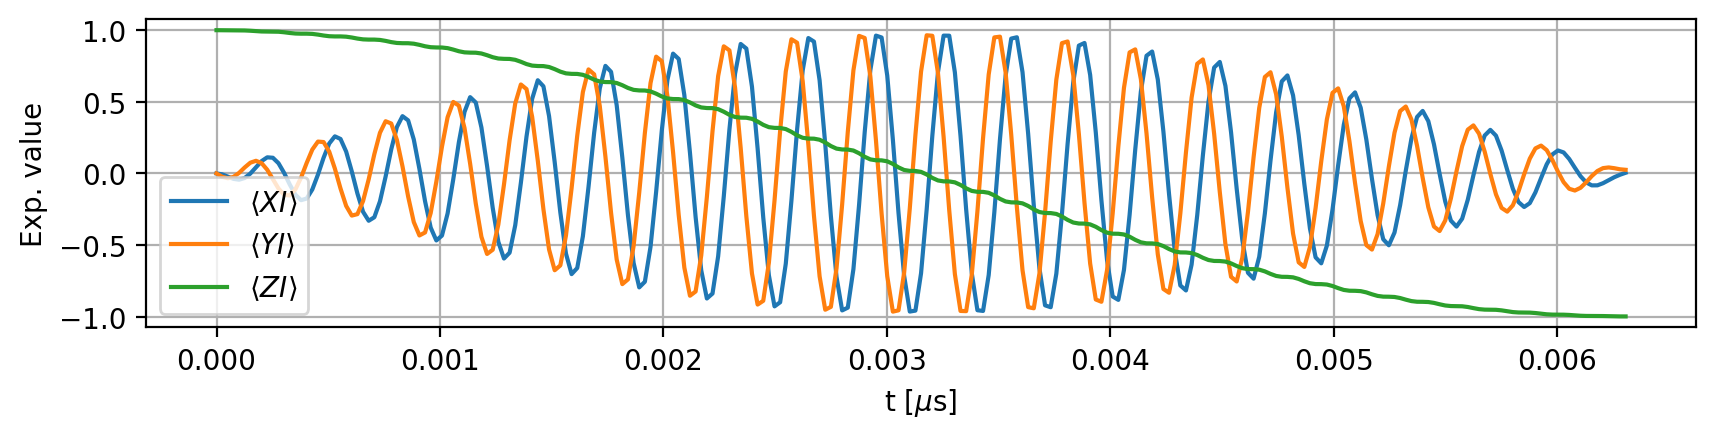

In [49]:
result.plot_expectation_value(['XI','YI','ZI'], frame='lab')

Bloch vectors are derived from the expectation values of the Pauli matrices. We can **plot the Bloch vectors** for all spins as follows:

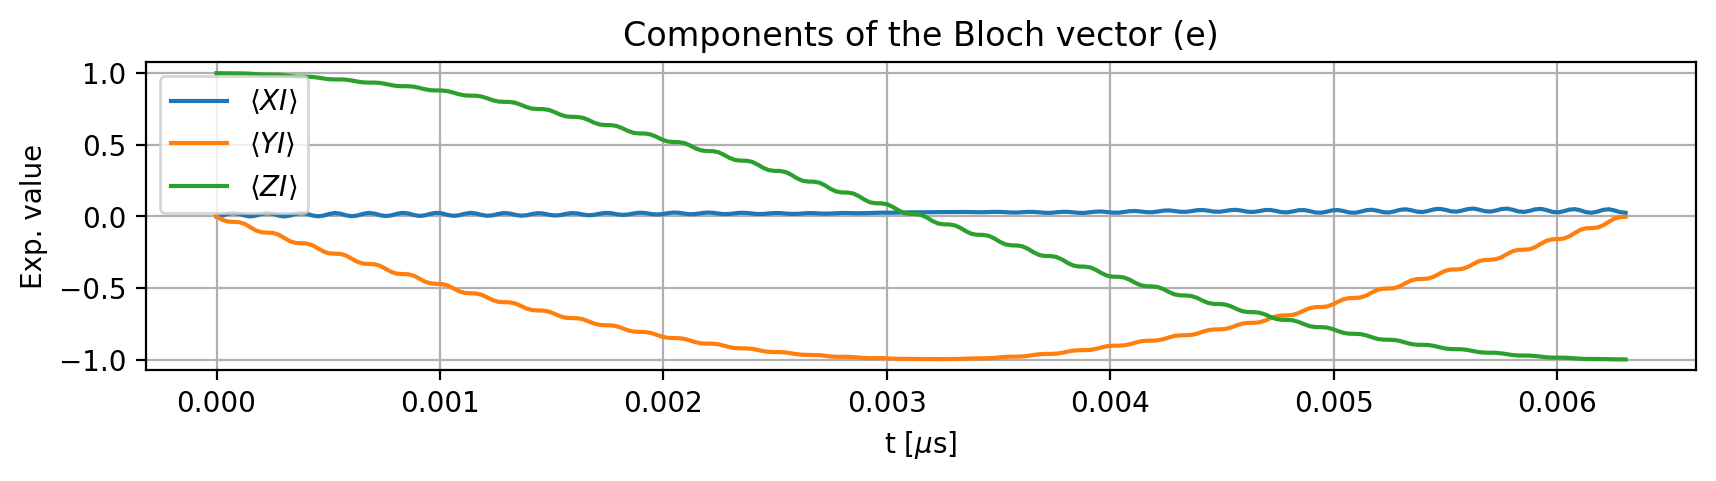

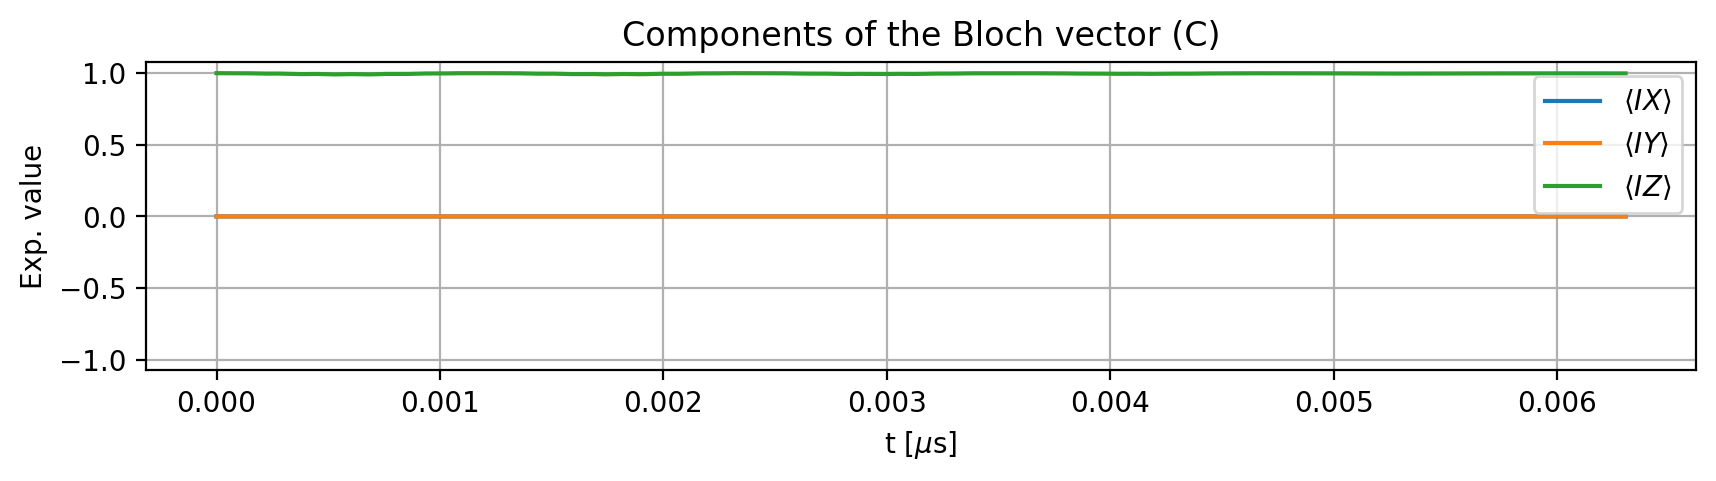

In [50]:
result.plot_Bloch_vectors()

By default, the method uses the rotating frame and the product basis to plot the Bloch vectors.

## Process matrix

The **process matrix** is one of the most informative ways to **characterize** and visualize **quantum processes** (in our case, to characterize the time evolution in the qubit subspace). Usually, it is defined via a quantum channel acting on a density matrix as:

$$
\varepsilon(\rho) = \frac{1}{2^n}\sum_{i,j=0}^{4^n-1}{\chi_{i,j} P_i \rho P_j},
$$

where $P$-s are the $n$-qubit Pauli basis elements (Pauli strings), and $\chi_{i,j}$ is the complex-valued $\chi$-matrix on the Pauli basis (process matrix), whose real and imaginary parts both fall within the range $[-1, 1]$.

The `process_matrix()` method calculates the **process matrix in a given basis and frame**. With the `t_idx` argument, you can control the time point at which the process matrix is calculated. **By default**, it is set to `-1`, the **endpoint of the time evolution**. The `spin_names` argument can be used to restrict the spins included in the analysis:

In [51]:
result.process_matrix(basis='product', frame='rotating', spin_names='e')

array([[ 3.9908e-06+0.0000e+00j, -9.2408e-04+1.7685e-03j, -5.4481e-07-2.4938e-07j, -1.2972e-05+2.2944e-05j],
       [-9.2408e-04-1.7685e-03j,  9.9769e-01+0.0000e+00j,  1.5643e-05+2.9918e-04j,  1.3174e-02+4.3372e-04j],
       [-5.4481e-07+2.4938e-07j,  1.5643e-05-2.9918e-04j,  8.9962e-08+0.0000e+00j,  3.3691e-07-3.9437e-06j],
       [-1.2972e-05-2.2944e-05j,  1.3174e-02-4.3372e-04j,  3.3691e-07+3.9437e-06j,  1.7451e-04+0.0000e+00j]])

You can plot the process matrix directly using the `plot_process_matrix()` method. There are two options:  
* `value='re-im'` to plot the real and imaginary parts of the complex process matrix  
* `value='abs'` to plot its absolute value

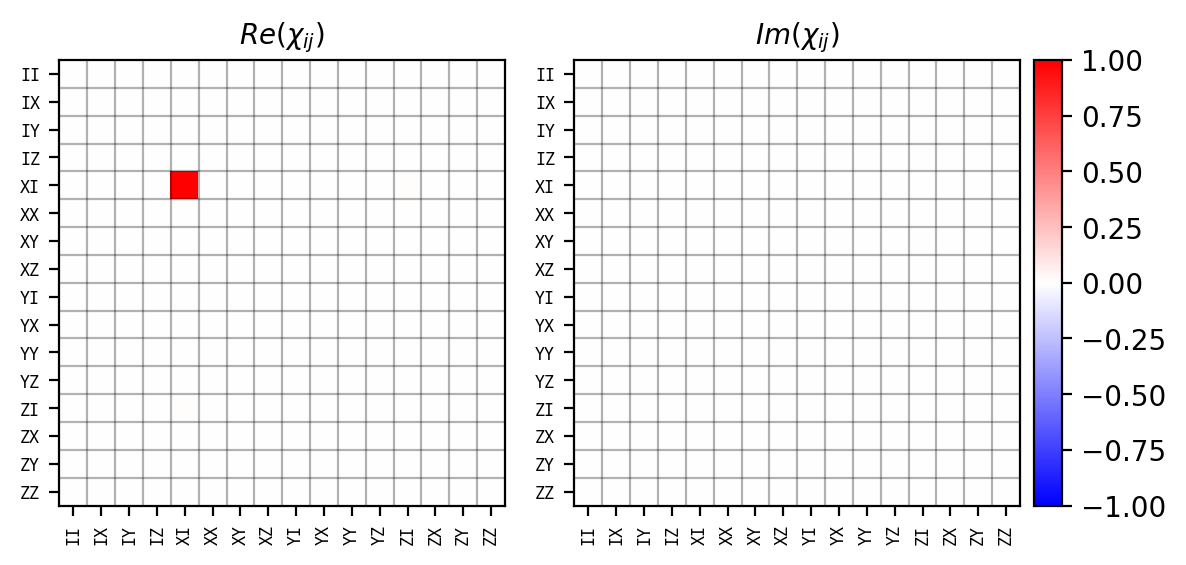

In [52]:
result.plot_process_matrix(value='re-im', basis='product', frame='rotating')

One also can control the visualized time point by the `t_idx` argument. For example, `t_idx=0` yields to an identity operation:

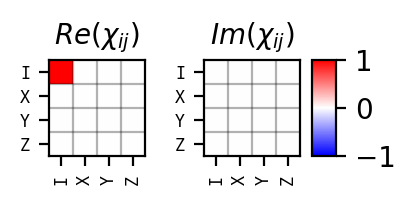

In [53]:
result.plot_process_matrix(value='re-im', t_idx=0, basis='product', frame='rotating', spin_names='e')

## Average gate fidelity

The **average gate fidelity** measures how closely the implemented gate or circuit matches the ideal one. Before calculating it, you need to **define the ideal quantum gate or circuit** to serve as a reference. This will be compared against the gate or circuit realized via time evolution. To do this, import Qiskit’s `QuantumCircuit` class and define the quantum circuit using gates:


In [54]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.x(0)
qc.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────

To calculate the average gate fidelity, add the `qc` to the `result` object:

In [55]:
result.ideal = qc

This automatically computes the ideal unitary operator:

In [56]:
result.ideal_unitary_matrix

array([[0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]])

The **average gate fidelity** can be calculated using:

In [57]:
result.average_gate_fidelity()

np.float64(0.9981510099594348)

When the average gate fidelity is calculated, the **averaging is performed over the pure states of the qubit subspace**.

The resulting average gate fidelity is very close to $1$, indicating that the pulse effectively implements an unconditional single-qubit $\text{RX}(\pi)$ gate within the electron spin qubit subspace. The small deviation from perfect fidelity arises from a weak — though not infinitesimally weak — excitation, which leads to non-ideal Rabi oscillations (as described by the Bloch–Siegert shift). <span style="font-variant: small-caps;">Simphony</span> simulates the **exact time evolution**, allowing such subtle errors to be revealed and analyzed.

## Leakage

The `leakage()` method computes the amount of population that has leaked outside the qubit subspace:

In [58]:
result.leakage(t_idx=[0,-1], shot='all')

array([[0.    , 0.0021]])

## Further advanced examples

* Default nitrogen-vacancy model and multiqubit tutorial
* Running Noisy Simulations on GPU tutorial
* Gate Optimization with Autodiff tutorial